In [2]:
#Basic Imports
import pandas as pd
import numpy as np

In [3]:
#sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing 
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.utils import class_weight
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [4]:
from keras.layers import LSTM,Dense,Dropout,Embedding,CuDNNLSTM,Bidirectional


In [5]:
from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.metrics import fbeta_score, make_scorer
from keras_preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [6]:
from tensorflow import keras

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from tqdm import tqdm


In [10]:
import sys

sys.path.insert(0, '/Users/seanyboy/Documents/Flatiron/Phase_4/Twitter_Sentiment_Project/Helper_Functions')
import functions as fn

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/seanyboy/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [11]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers

In [12]:
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk import  word_tokenize
from gensim.models import word2vec
from nltk import pos_tag
from keras.preprocessing.text import Tokenizer


### Import Dataset with Additional Negative Examples

In [64]:
new_df = pd.read_csv('additional_negs')


In [65]:
new_df['processed_text'] = fn.Process_Tweet(new_df['tweet_text'],remove_HTML=True,replace_moji_bake=True,strip_links=True,no_leading=True,contraction_fix=True,remove_numerals=True,remove_hashtags=False,remove_mentions=True)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


#### Adjusting Target Values

In [66]:
#Combinging Neutral and Positive Values
new_df['Sentiment']=new_df['Sentiment'].replace({"Positive": 0, "Negative": 1, "Neutral": 3}).astype(np.uint8)
#Setting the Minority Class Negative as the Value of "1"
new_df['Sentiment']=new_df['Sentiment'].replace(3,0).copy()


In [67]:
# new_df = new_df[new_df['Sentiment']!='Neutral']


In [68]:
new_df['Sentiment'].value_counts(normalize=True)


0    0.823831
1    0.176169
Name: Sentiment, dtype: float64

### Tokenizing and Lemmatization

At this step I will again perform the same lemmatization performed on the traditional models. I will not use the same pipeline as it creates TFIDF vectors. I will be using the pretrained GLOVE vectors.

In [69]:
#Import Stopwords
sw = stopwords.words('english')
len(sw)

179

There are a 179 stopwords in this list, I may experiment with adding stopwords at some point.

In [70]:
len(sw)


179

In [71]:
from keras.preprocessing.text import Tokenizer

t  = Tokenizer()

In [72]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [73]:
tokenizer = TfidfVectorizer.build_tokenizer

In [74]:
new_df['processed_text']

0         I have a  three G iPhone. After  three  hrs t...
1         Know about  ? Awesome iPad/iPhone app that yo...
2         Can not wait for #iPad  two  also. They shoul...
3         I hope this year's festival is not as crashy ...
4         great stuff on Fri #SXSW: Marissa Mayer (Goog...
                               ...                        
10150    RT : Thinking of upgrading to #Yosemite? Think...
10151               why is not group facetime a thing  wtf
10152    Being held hostage at  - They are replacing th...
10153    hey  is it normal for my laptop charger to be ...
10154    My iPhone  five 's photos are no longer downlo...
Name: processed_text, Length: 10155, dtype: object

In [75]:
new_df

,tweet_text,Product,Sentiment,processed_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,1,I have a three G iPhone. After three hrs t...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,0,Know about ? Awesome iPad/iPhone app that yo...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,0,Can not wait for #iPad two also. They shoul...
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,1,I hope this year's festival is not as crashy ...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,0,great stuff on Fri #SXSW: Marissa Mayer (Goog...
...,...,...,...,...
10150,RT @Ecofantasy: Thinking of upgrading to #Yose...,Apple,1,RT : Thinking of upgrading to #Yosemite? Think...
10151,why isnt group facetime a thing @apple wtf,Apple,1,why is not group facetime a thing wtf
10152,Being held hostage at @apple - They are replac...,Apple,1,Being held hostage at - They are replacing th...
10153,hey @apple is it normal for my laptop charger ...,Apple,1,hey is it normal for my laptop charger to be ...


In [76]:
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

I will take advantage of the doc preparer function that takes in a the words from the dataset and replaces any remaining punctuation, removes stopwords, and lemmatizes the words in the dataset. 

In [77]:
def doc_preparer(doc, stop_words=sw):
    '''
    
    :param doc: a document from a corpus
    :return: a document string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
#     doc = pos_tag(doc)
#     doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
#     lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()
#     doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return doc


In [78]:
# new_df['processed_text']=[doc_preparer(doc, sw) for doc in new_df['processed_text']]


In [79]:
new_df.head(5)


,tweet_text,Product,Sentiment,processed_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,1,I have a three G iPhone. After three hrs t...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,0,Know about ? Awesome iPad/iPhone app that yo...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,0,Can not wait for #iPad two also. They shoul...
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,1,I hope this year's festival is not as crashy ...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,0,great stuff on Fri #SXSW: Marissa Mayer (Goog...


In [80]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10155 entries, 0 to 10154
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_text      10155 non-null  object
 1   Product         4501 non-null   object
 2   Sentiment       10155 non-null  uint8 
 3   processed_text  10155 non-null  object
dtypes: object(3), uint8(1)
memory usage: 248.0+ KB


### Adding Glove Word Embeddings

#### Train/Test Split

In [81]:
new_df['processed_text']

0         I have a  three G iPhone. After  three  hrs t...
1         Know about  ? Awesome iPad/iPhone app that yo...
2         Can not wait for #iPad  two  also. They shoul...
3         I hope this year's festival is not as crashy ...
4         great stuff on Fri #SXSW: Marissa Mayer (Goog...
                               ...                        
10150    RT : Thinking of upgrading to #Yosemite? Think...
10151               why is not group facetime a thing  wtf
10152    Being held hostage at  - They are replacing th...
10153    hey  is it normal for my laptop charger to be ...
10154    My iPhone  five 's photos are no longer downlo...
Name: processed_text, Length: 10155, dtype: object

In [82]:
X = new_df['processed_text']
y = new_df['Sentiment']


In [83]:
len(X)

10155

In [84]:
#Splitting First into a Train Set and Remaing Data Set
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8,random_state=42,stratify=y)


In [85]:
#SPlitting the Remaining Data into Validation and Test Data
X_val, X_test, y_val, y_test = train_test_split(X_rem,y_rem, test_size=0.5,random_state=42,stratify=y_rem)


In [86]:
len(X_val)


1015

I have split the data twice, the holdout data will be the final data to test on for all the models that I will attempt.

### Tokenizing for Glove Model

In [87]:
X_train_tokens=[doc_preparer(doc, sw) for doc in X_train]
X_val_tokens = [doc_preparer(doc, sw) for doc in X_val]
X_test_tokens = [doc_preparer(doc,sw) for doc in X_test]

In [88]:
X_train_tokens

[['sxsw',
  'mistakes',
  'made',
  'building',
  'netflix',
  'iphone',
  'plus',
  'see',
  'source',
  'code'],
 ['great',
  'visualisation',
  'ghost',
  'movement',
  'logic',
  'pacman',
  'google',
  'doodles',
  'session',
  'sxsw',
  'details'],
 ['iphone',
  'worries',
  'drop',
  'one',
  'venues',
  'talk',
  'concierge',
  'take',
  'care',
  'sxsw',
  'sxswi'],
 ['heard',
  'downtown',
  'location',
  'sold',
  'one',
  'merchandise',
  'last',
  'night',
  'sxsw',
  'apple',
  'ipad',
  'two'],
 ['google',
  'tweet',
  'new',
  'think',
  'speak',
  'mark',
  'belinsky',
  'nine',
  'hundred',
  'eleven',
  'tweets',
  'panel',
  'sxsw'],
 ['sxsw',
  'recap',
  'day',
  'four',
  'greaaat',
  'exploring',
  'brand',
  'mascots',
  'digital',
  'age',
  'sxsw',
  'hotsheet'],
 ['okay',
  'fair',
  'enough',
  'lining',
  'new',
  'tech',
  'cost',
  'sxsw',
  'much',
  'better',
  'new',
  'ipad'],
 ['rt',
  'saw',
  'lax',
  'heading',
  'sxsw',
  'wife',
  'iphone',
  '

In [89]:
#Adding all the tokens to a variable
data = X_train_tokens


In [90]:
#Create Set of Unique Tokens
total_vocabulary = set(word for tweet in data for word in tweet)


In [91]:
len(total_vocabulary)


9065

In [95]:
#Createa dictionay that takes the glove embeddings and attatches them to the words in the dataset
embedding_vector = {}
with open('/Users/seanyboy/Documents/Flatiron/Phase_4/Twitter_Sentiment_Project/Data/glove.6B.50d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            embedding_vector[word] = vector

In [96]:
# Creating Sequence Tokens
token = Tokenizer()
token.fit_on_texts(X_train)
seq = token.texts_to_sequences(X_train)


In [97]:
X_train_tokens[0:4]


[['sxsw',
  'mistakes',
  'made',
  'building',
  'netflix',
  'iphone',
  'plus',
  'see',
  'source',
  'code'],
 ['great',
  'visualisation',
  'ghost',
  'movement',
  'logic',
  'pacman',
  'google',
  'doodles',
  'session',
  'sxsw',
  'details'],
 ['iphone',
  'worries',
  'drop',
  'one',
  'venues',
  'talk',
  'concierge',
  'take',
  'care',
  'sxsw',
  'sxswi'],
 ['heard',
  'downtown',
  'location',
  'sold',
  'one',
  'merchandise',
  'last',
  'night',
  'sxsw',
  'apple',
  'ipad',
  'two']]

In [98]:
seq[0:4]


[[1, 951, 264, 451, 952, 7, 17, 565, 93, 3, 99, 156, 824, 566],
 [100,
  5195,
  16,
  2,
  3550,
  1716,
  1972,
  13,
  3551,
  170,
  2,
  11,
  825,
  201,
  1,
  86,
  339,
  79],
 [71,
  17,
  71,
  3552,
  953,
  181,
  31,
  16,
  97,
  3553,
  12,
  182,
  3,
  8,
  3554,
  48,
  37,
  279,
  1209,
  16,
  19,
  1,
  70],
 [15, 222, 2, 101, 153, 423, 31, 378, 13, 5196, 154, 258, 1, 10, 6, 14]]

In [99]:
    max([len(x)for x in seq])

48

In [100]:
train_seq = pad_sequences(seq,maxlen=40,padding='pre')

The lists of tokens have been changed to numpy arrays that are padded with 

In [101]:
train_seq[0:4]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    1,  951,  264,  451,  952,    7,   17,
         565,   93,    3,   99,  156,  824,  566],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
         100, 5195,   16,    2, 3550, 1716, 1972,   13, 3551,  170,    2,
          11,  825,  201,    1,   86,  339,   79],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,   71,   17,   71, 3552,  953,
         181,   31,   16,   97, 3553,   12,  182,    3,    8, 3554,   48,
          37,  279, 1209,   16,   19,    1,   70],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,   15,  222,  

In [102]:
train_seq.shape

(8124, 40)

In [103]:
vocab_size = len(token.word_index)+1

In [104]:
embedding_matrix = np.zeros((vocab_size,50))
for word,i in tqdm(token.word_index.items()):
    embedding_value = embedding_vector.get(word)
    if embedding_value is not None:
        embedding_matrix[i] = embedding_value

100%|███████████████████████████████████| 9486/9486 [00:00<00:00, 318674.65it/s]


In [105]:
embedding_matrix.shape

(9487, 50)

### Baseline LSTM Model

#### Class Weights

This is an imbalanced dataset so I will compute the class weights with sklearn's class weight utility.

In [106]:
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=[0,1],y=y_train)


In [107]:
class_weight=dict(zip([0,1],class_weights))


#### Metrics For Modeling

These are variety of metrics to choose from for early stopping during the training of the neural networks.

In [108]:
metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name='AUC'),
    keras.metrics.PrecisionAtRecall(name='PatR',recall=0.78)
]

2022-09-16 14:19:07.884739: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Early Stopping

I will use early stopping in order to hopefully find the best model and prevent overfitting. I will first attempt to use recall as the guide for the early topping, leaving 

In [109]:
es = EarlyStopping(monitor='val_recall', mode='max', verbose=1,patience=10,restore_best_weights=True)

In [110]:
model=Sequential()
model.add(Embedding(vocab_size,50,weights=[embedding_matrix],input_length=40,trainable=False))
model.add(layers.LSTM(units=64))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(32))
model.add(layers.Dense(1, activation="sigmoid"))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=metrics)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 50)            474350    
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 505,903
Trainable params: 31,553
Non-trainable params: 474,350
_________________________________________________________________


In [111]:
history = model.fit(train_seq,y_train,epochs = 50,batch_size=32,validation_split=0.2,class_weight=class_weight,callbacks=[es])

Epoch 1/50
204/204 [==============================] - 13s 37ms/step - loss: 0.4169 - fn: 271.0000 - fp: 726.0000 - tn: 4633.0000 - tp: 869.0000 - precision: 0.5448 - recall: 0.7623 - AUC: 0.8838 - PatR: 0.5083 - val_loss: 0.3521 - val_fn: 76.0000 - val_fp: 173.0000 - val_tn: 1161.0000 - val_tp: 215.0000 - val_precision: 0.5541 - val_recall: 0.7388 - val_AUC: 0.8782 - val_PatR: 0.4820
Epoch 2/50
204/204 [==============================] - 6s 31ms/step - loss: 0.3310 - fn: 265.0000 - fp: 400.0000 - tn: 4959.0000 - tp: 875.0000 - precision: 0.6863 - recall: 0.7675 - AUC: 0.9188 - PatR: 0.6422 - val_loss: 0.4022 - val_fn: 65.0000 - val_fp: 220.0000 - val_tn: 1114.0000 - val_tp: 226.0000 - val_precision: 0.5067 - val_recall: 0.7766 - val_AUC: 0.8859 - val_PatR: 0.4967
Epoch 3/50
204/204 [==============================] - 7s 36ms/step - loss: 0.3106 - fn: 248.0000 - fp: 361.0000 - tn: 4998.0000 - tp: 892.0000 - precision: 0.7119 - recall: 0.7825 - AUC: 0.9289 - PatR: 0.7189 - val_loss: 0.3068

#### First Evaluation - Training

In [112]:
predict = model.predict(train_seq)
y_pred = [1 * (x[0]>=0.5) for x in predict]


254/254 [==============================] - 3s 10ms/step


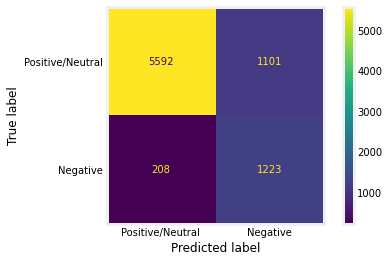

In [113]:
plt.style.use('fivethirtyeight')
ConfusionMatrixDisplay.from_predictions(y_train,y_pred,display_labels=['Positive/Neutral','Negative'])
plt.grid(False)
plt.show()

In [115]:
print(fn.classification_report(y_train,y_pred))


              precision    recall  f1-score   support

           0       0.96      0.84      0.90      6693
           1       0.53      0.85      0.65      1431

    accuracy                           0.84      8124
   macro avg       0.75      0.85      0.77      8124
weighted avg       0.89      0.84      0.85      8124



Compared to the conventional models, this model did a great job on recall for the negative class that is sought after, but the precision score is troubling, another model iteration needs to address this.

#### First Evaluation Validation

##### Transforming with Tokenizer

In [116]:
#Tokenizing on the validation Set
X_val_tokens = token.texts_to_sequences(X_val)
#Creating the validation sequences
val_seq = pad_sequences(X_val_tokens,maxlen=40)

In [117]:
#Predicting on validation Set
val_pred = model.predict(val_seq)
y_val_pred = [1 * (x[0]>=0.5) for x in val_pred]

32/32 [==============================] - 0s 13ms/step


In [118]:
print(fn.classification_report(y_val,y_val_pred))

              precision    recall  f1-score   support

           0       0.95      0.84      0.89       836
           1       0.52      0.82      0.63       179

    accuracy                           0.83      1015
   macro avg       0.74      0.83      0.76      1015
weighted avg       0.88      0.83      0.85      1015



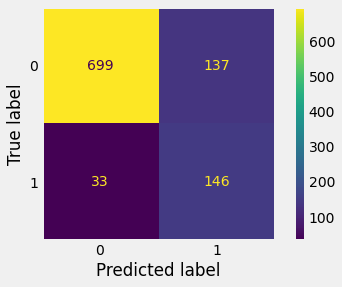

In [119]:
plt.style.use('fivethirtyeight')
ConfusionMatrixDisplay.from_predictions(y_val,y_val_pred)
plt.grid(False)
plt.show()

This is a mixed bag of evaluation. The neural network does appear to be slightly overfitting, but a bigger problem is the struggle with precision for the model. The model is struggling to separate positive from negative, the cases of very negative may be very clear to the model, but it's performance could indeed be better.

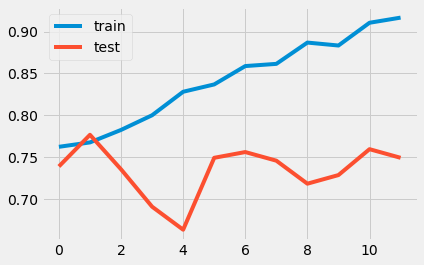

In [120]:
plt.plot(history.history['recall'], label='train')
plt.plot(history.history['val_recall'], label='test')
plt.legend()
plt.show()

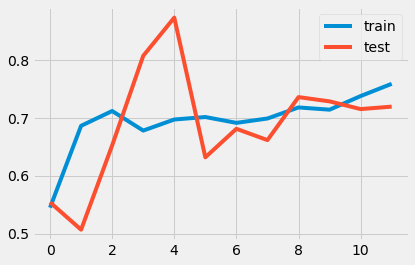

In [121]:
plt.plot(history.history['precision'], label='train')
plt.plot(history.history['val_precision'], label='test')
plt.legend()
plt.show()

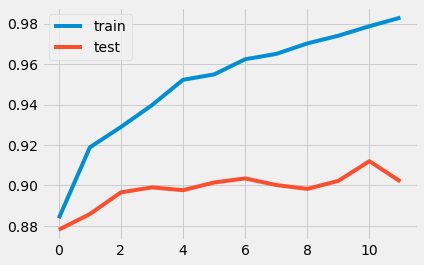

In [122]:
plt.plot(history.history['AUC'], label='train')
plt.plot(history.history['val_AUC'], label='test')
plt.legend()
plt.show()

Frustratingly the above charts reveal the difficulty with training epochs, as the 4th epoch was the highest validation score of recall, but the lowest for precision. I need to find a way to have the scores match better.

### Second LSTM Model

For this second model I am using the an fbeta score function, using a beta of 1.75, leaning more towards recall than precision as the last LSTM model showed a unacceptably low precision score. The fbeta score will be the determining metric for the early stopping on this model iteration.

In [123]:
from keras import backend as K
THRESHOLD = 0.5

def fbeta(y_true, y_pred, beta = 1.75, threshold_shift=0.5-THRESHOLD):   
    # just in case 
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall) 


In [124]:
model=Sequential()
model.add(Embedding(vocab_size,50,weights=[embedding_matrix],input_length=40,trainable=False))
model.add(Bidirectional(LSTM(units=64)))
model.add(Dense(64, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation="sigmoid"))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=fbeta,run_eagerly=True)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 40, 50)            474350    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              58880     
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 541,551
Trainable params: 67,201
Non-trainable params: 474,350
___________________________________________

In [126]:
es = EarlyStopping(monitor='val_fbeta', mode='max', verbose=1,patience=5,restore_best_weights=True)


In [127]:
history = model.fit(train_seq,y_train,epochs = 100,batch_size=32,validation_split=0.2,class_weight=class_weight,callbacks=[es])

Epoch 1/100
204/204 [==============================] - 55s 268ms/step - loss: 0.4180 - fbeta: 0.6739 - val_loss: 0.4174 - val_fbeta: 0.6714
Epoch 2/100
204/204 [==============================] - 54s 265ms/step - loss: 0.3246 - fbeta: 0.7247 - val_loss: 0.2535 - val_fbeta: 0.6934
Epoch 3/100
204/204 [==============================] - 54s 266ms/step - loss: 0.3021 - fbeta: 0.7413 - val_loss: 0.3244 - val_fbeta: 0.7057
Epoch 4/100
204/204 [==============================] - 54s 262ms/step - loss: 0.2856 - fbeta: 0.7443 - val_loss: 0.2596 - val_fbeta: 0.7112
Epoch 5/100
204/204 [==============================] - 54s 265ms/step - loss: 0.2625 - fbeta: 0.7761 - val_loss: 0.2828 - val_fbeta: 0.7103
Epoch 6/100
204/204 [==============================] - 54s 264ms/step - loss: 0.2497 - fbeta: 0.7851 - val_loss: 0.3034 - val_fbeta: 0.7175
Epoch 7/100
204/204 [==============================] - 59s 291ms/step - loss: 0.2316 - fbeta: 0.8009 - val_loss: 0.2606 - val_fbeta: 0.7337
Epoch 8/100
204/204 

In [145]:
predict = model.predict(train_seq)
y_pred = [1 * (x[0]>=0.5) for x in predict]

254/254 [==============================] - 77s 302ms/step


In [129]:
print(fn.classification_report(y_train,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      6693
           1       0.86      0.92      0.89      1431

    accuracy                           0.96      8124
   macro avg       0.92      0.94      0.93      8124
weighted avg       0.96      0.96      0.96      8124



In [130]:
predict = model.predict(val_seq)
y_val_pred = [1 * (x[0]>=0.5) for x in predict]

32/32 [==============================] - 4s 109ms/step


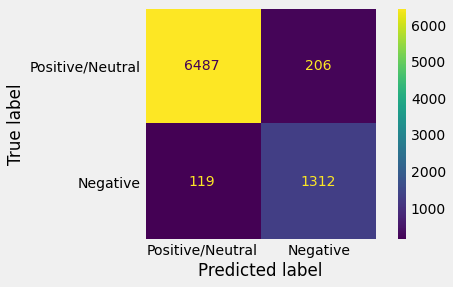

In [131]:
plt.style.use('fivethirtyeight')
ConfusionMatrixDisplay.from_predictions(y_train,y_pred,display_labels=['Positive/Neutral','Negative'])
plt.grid(False)
plt.show()

In [132]:
print(fn.classification_report(y_val,y_val_pred))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95       836
           1       0.74      0.77      0.75       179

    accuracy                           0.91      1015
   macro avg       0.84      0.85      0.85      1015
weighted avg       0.91      0.91      0.91      1015



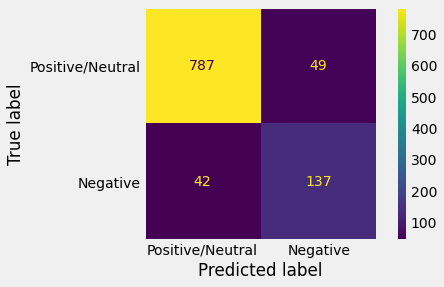

In [133]:
plt.style.use('fivethirtyeight')
ConfusionMatrixDisplay.from_predictions(y_val,y_val_pred,display_labels=['Positive/Neutral','Negative'])
plt.grid(False)
plt.show()

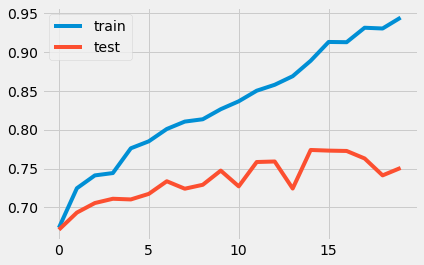

In [134]:
plt.plot(history.history['fbeta'], label='train')
plt.plot(history.history['val_fbeta'], label='test')
plt.legend()
plt.show()

### Third Model Iteration

For this third iteration I have added another LSTM layer. There is a 10% dropout. I am allowing a 10 of patience for the early stopping this time and increasing the epochs to 200, yes it's a lot of epochs, but the early stopping will prevent extensive overfitting.

In [135]:
model=Sequential()
model.add(Embedding(vocab_size,50,weights=[embedding_matrix],input_length=40,trainable=False))
model.add(Bidirectional(LSTM(128,return_sequences=True,)))
model.add(Dense(256, activation='relu'))
model.add(Bidirectional(LSTM(64)))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation="sigmoid"))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=fbeta,run_eagerly=True)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 40, 50)            474350    
                                                                 
 bidirectional_1 (Bidirectio  (None, 40, 256)          183296    
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 40, 256)           65792     
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)               

In [136]:
es = EarlyStopping(monitor='val_fbeta', mode='max', verbose=1,patience=10,restore_best_weights=True)


In [137]:
history = model.fit(train_seq,y_train,epochs = 200,batch_size=32,validation_split=0.2,class_weight=class_weight,callbacks=[es])

Epoch 1/200
204/204 [==============================] - 196s 961ms/step - loss: 0.3876 - fbeta: 0.6904 - val_loss: 0.3325 - val_fbeta: 0.7145
Epoch 2/200
204/204 [==============================] - 193s 948ms/step - loss: 0.3363 - fbeta: 0.7313 - val_loss: 0.2905 - val_fbeta: 0.7007
Epoch 3/200
204/204 [==============================] - 206s 1s/step - loss: 0.2974 - fbeta: 0.7273 - val_loss: 0.2799 - val_fbeta: 0.7134
Epoch 4/200
204/204 [==============================] - 191s 936ms/step - loss: 0.2960 - fbeta: 0.7413 - val_loss: 0.3355 - val_fbeta: 0.6863
Epoch 5/200
204/204 [==============================] - 221s 1s/step - loss: 0.2686 - fbeta: 0.7634 - val_loss: 0.2653 - val_fbeta: 0.7099
Epoch 6/200
204/204 [==============================] - 202s 985ms/step - loss: 0.2553 - fbeta: 0.7755 - val_loss: 0.2851 - val_fbeta: 0.7247
Epoch 7/200
204/204 [==============================] - 193s 946ms/step - loss: 0.2487 - fbeta: 0.7917 - val_loss: 0.2765 - val_fbeta: 0.7301
Epoch 8/200
204/204

In [139]:
history.history.keys()

dict_keys(['loss', 'fbeta', 'val_loss', 'val_fbeta'])

In [140]:
predict = model.predict(val_seq)
y_val_pred = [1 * (x[0]>=0.5) for x in predict]

32/32 [==============================] - 9s 287ms/step


In [141]:
print(fn.classification_report(y_val,y_val_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       836
           1       0.75      0.75      0.75       179

    accuracy                           0.91      1015
   macro avg       0.85      0.85      0.85      1015
weighted avg       0.91      0.91      0.91      1015



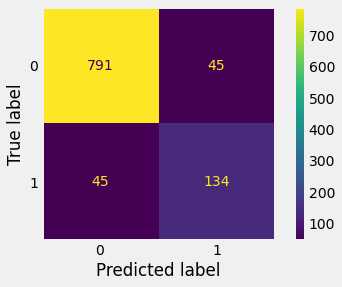

In [142]:
plt.style.use('fivethirtyeight')
ConfusionMatrixDisplay.from_predictions(y_val,y_val_pred)
plt.grid(False)
plt.show()

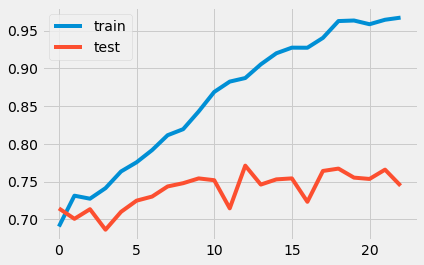

In [143]:
plt.plot(history.history['fbeta'], label='train')
plt.plot(history.history['val_fbeta'], label='test')
plt.legend()
plt.show()

Despite my best efforts I can't get the Neural Network Model to achieve more than a .77 on recall score on the validation set. It's a good score, but given the higher level of interpretability, I will probably opt for the simpler models.

### Conclusions

Experimenting with the neural networks proved difficult. I struggled to match by best scores from using simpler models, but the dimensionality of the vectors on the Glove model may have been the difference compared to the vectors of the TFIDF and bag of words models.